In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk # wonderful tutorial can be found here https://pythonprogramming.net/tokenizing-words-sentences-nltk-tutorial/

%matplotlib inline

In [2]:
df = pd.read_csv('amazon_alexa.tsv', sep='\t')

# Initial data exploration

In [3]:
df.head(10)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [4]:
df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


It seems unreasonable to use any data except for the reviews and their rating. We could have product variation categorized and then create chart which one is the best, but it is outside the scope of the problem. Feedback and date are also unnecessary.

Second, the distribution of ratings in dataset is way off. 25-th percentile already has value of 4, and 50-th - of 5. If there is enough data for different ratings, it would seem reasonable to construct a subset with better distribution.

In [5]:
#omitting unnecessary columns
cdf = df[['rating', 'verified_reviews']]

print(cdf['rating'].value_counts())

5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64


In [6]:
cdf = pd.concat([cdf[cdf['rating'] < 5], cdf[cdf['rating'] == 5].sample(frac=1).iloc[:300]])
cdf['rating'].describe()

count    1164.000000
mean        3.547251
std         1.326495
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

Perfect dataset supposed to have equal amount of items with every rating, and their mean should be 3.0. Constructing such dataset would shrink dataset to 480 entries. Instead we can have dataset with 1164 entries with a mean of 3.5. That could create a shift in models predictions, but more data will help prevent overfitting and help model generalize data better.

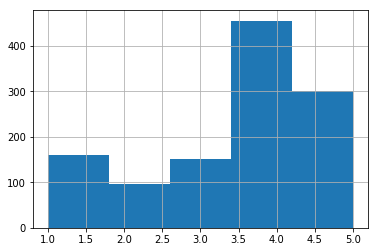

In [7]:
cdf['rating'].hist(bins=5)

# Assessing word vectors data

One of the most precise method when analysing natural language is to use word2vec approach. Let's check how many different words there is and create a full set of all used words in review. That would be useful later when chosing pre-trained word vectors.

In [8]:
text_body = ''
for row in cdf.iterrows():
    text_body += row[1]['verified_reviews'] + ' '
    
cleaned_text_body = re.sub('[^a-zA-Z]', ' ', text_body)
word_list = nltk.tokenize.word_tokenize(cleaned_text_body.lower())
word_set = set(word_list)

In [9]:
len(word_set)

2954

Now that we got complete set of words used in dataset we can estimate how good or bad a certain vectorization of words could serve.

In [10]:
embeddings = {}
f = open('glove.6B/glove.6B.100d.txt', 'r', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings[word] = vector
f.close()

In [11]:
def assess_embeddings(set_of_words):
    c = 0
    missing_embeddings = []
    for word in set_of_words:
        if word in embeddings:
            c+=1
        else:
            missing_embeddings.append(word)

    print(c/len(set_of_words)*100, 'percents of words in reviews are covered in embeddings')
    return missing_embeddings

missing_embeddings = assess_embeddings(word_set)    

97.05484089370346 percents of words in reviews are covered in embeddings


In [12]:
print(sorted(missing_embeddings))

['accessable', 'accesss', 'alexas', 'amozon', 'anypod', 'audioapple', 'becausse', 'bettter', 'buld', 'chachki', 'chromecast', 'comeletely', 'compacity', 'complacated', 'controll', 'cordthank', 'cortna', 'creapy', 'culas', 'defuser', 'deviceoverall', 'dhiw', 'electeonically', 'emoji', 'escencia', 'eveyday', 'exho', 'feee', 'firestick', 'firmare', 'glitching', 'hadn', 'hahaawesome', 'helful', 'homescreen', 'hubbed', 'huele', 'imhave', 'imrproved', 'indundated', 'intelagence', 'ipdates', 'isue', 'kwikset', 'lifht', 'lleg', 'looooooove', 'lve', 'madlibs', 'majes', 'minorly', 'nois', 'ontrac', 'overa', 'perdi', 'philipshue', 'pleasedsimple', 'powercord', 'practicalthan', 'primeday', 'promp', 'qualty', 'qued', 'rcieved', 'reccomend', 'receivded', 'refurb', 'returnef', 'ryp', 'screamig', 'screenless', 'seprately', 'settins', 'sinqued', 'sirrius', 'smartbon', 'smartthing', 'smartthings', 'soluci', 'soundtouch', 'sqyxtw', 'subscriptiondoes', 'tulos', 'udefulness', 'usde', 'viceo', 'wellfour']


Embeddings successfully cover almost all word set, except for some typos. Since typos are only ~3% of words, we can ignore the problem unless we would want to improve accuracy.

We will use the Keras library to solve the problem

In [13]:
import keras

Using TensorFlow backend.


# Preparing data

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [15]:
tokenizer = Tokenizer(num_words=len(word_set))
tokenizer.fit_on_texts([cleaned_text_body])
print('Words in word_index:', len(tokenizer.word_index))

Words in word_index: 2955


As we could expect, keras' tokenizer uses an algorithm that is somewhat different from the one we chose earlier. However, the amount of words in created word_index is bigger only by 1. Generally, it is better to use already made solutions than to create something from scratch. Let's quickly assess this word_index and make a decision whether it is reasonable to use it.

In [16]:
_ = assess_embeddings(set([kvp for kvp in tokenizer.word_index]))

97.05583756345177 percents of words in reviews are covered in embeddings


The results are just as good, so the tokenizer's word_index stays.

In [17]:
cdf['cleaned_text'] = cdf['verified_reviews'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
cdf['cleaned_text'] = cdf['cleaned_text'].apply(lambda x: re.sub(' +',' ', x)) #remove consecutive spacing

In [18]:
cdf['sequences'] = cdf['cleaned_text'].apply(lambda x: tokenizer.texts_to_sequences([x])[0])
cdf['sequences'].head(10)

2     [214, 232, 185, 6, 1781, 20, 28, 261, 6, 441, ...
6     [134, 115, 6, 1262, 2, 262, 35, 156, 11, 108, ...
19    [2, 515, 1, 294, 15, 13, 7, 1, 143, 12, 1266, ...
22    [18, 75, 70, 4, 68, 33, 9, 6, 241, 345, 63, 51...
24    [2, 113, 6, 236, 242, 9, 1, 234, 2, 26, 597, 1...
28    [141, 194, 3, 60, 16, 5, 57, 178, 3, 139, 214,...
31                                           [2, 24, 4]
33    [1, 195, 36, 179, 56, 9, 186, 31, 200, 5, 158,...
37                        [41, 7, 62, 72, 471, 275, 15]
42                                    [31, 118, 31, 56]
Name: sequences, dtype: object

In [19]:
# Need to know max_sequence_length to pad other sequences
max_sequence_length = cdf['sequences'].apply(lambda x: len(x)).max()
cdf['padded_sequences'] = cdf['sequences'].apply(lambda x: pad_sequences([x], max_sequence_length)[0])

In [20]:
print(cdf['padded_sequences'][2])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0  

Now split into train, validation and test subsets

In [21]:
train = cdf.sample(frac=0.8)
test_and_validation = cdf.loc[~cdf.index.isin(train.index)]
validation = test_and_validation.sample(frac=0.5)
test = test_and_validation.loc[~test_and_validation.index.isin(validation.index)]

print(train.shape, validation.shape, test.shape)

(931, 5) (116, 5) (117, 5)


In [39]:
def get_arrayed_data(df_set):
    setX = np.stack(df_set['padded_sequences'].values, axis=0)
    setY = pd.get_dummies(df_set['rating']).values #using one-hot encoding
    
    return (setX, setY)

trainX, trainY = get_arrayed_data(train)
validationX, validationY = get_arrayed_data(validation)
testX, testY = get_arrayed_data(test)

# Building the model

In [23]:
from keras.layers import Embedding

In [24]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    # words that are not in pretrained embedding will be zero vectors.
    if word in embeddings:
        embedding_matrix[i] = embeddings[word]

In [69]:
embedding_layer = Embedding(len(tokenizer.word_index) + 1, 100,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)

In [135]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Flatten, Dropout

In [70]:
def simple_reccurent_model(input_shape, output_shape):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(64, dropout=0.2))
    #model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    return model

In [74]:
model = simple_reccurent_model(trainX.shape[1], trainY.shape[1])
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [75]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 370, 100)          295600    
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325       
Total params: 342,325
Trainable params: 46,725
Non-trainable params: 295,600
_________________________________________________________________


In [77]:
model.fit(trainX, trainY, batch_size=64, epochs=100)

Epoch 1/100
931/931 [==============================] - 5s - loss: 1.1755 - acc: 0.5059     
Epoch 2/100
931/931 [==============================] - 5s - loss: 1.1378 - acc: 0.5209     
Epoch 3/100
931/931 [==============================] - 5s - loss: 1.0949 - acc: 0.5231     
Epoch 4/100
931/931 [==============================] - 5s - loss: 1.0747 - acc: 0.5478     
Epoch 5/100
931/931 [==============================] - 5s - loss: 1.0723 - acc: 0.5403     
Epoch 6/100
931/931 [==============================] - 5s - loss: 1.0432 - acc: 0.5736     
Epoch 7/100
931/931 [==============================] - 5s - loss: 1.0022 - acc: 0.5789     
Epoch 8/100
931/931 [==============================] - 5s - loss: 0.9854 - acc: 0.6026     
Epoch 9/100
931/931 [==============================] - 5s - loss: 0.9538 - acc: 0.6165     
Epoch 10/100
931/931 [==============================] - 5s - loss: 0.9474 - acc: 0.6208     
Epoch 11/100
931/931 [==============================] - 5s - loss: 0.8756 - acc

931/931 [==============================] - 5s - loss: 0.1090 - acc: 0.9549     
Epoch 90/100
931/931 [==============================] - 5s - loss: 0.1096 - acc: 0.9560     
Epoch 91/100
931/931 [==============================] - 5s - loss: 0.1088 - acc: 0.9581     
Epoch 92/100
931/931 [==============================] - 5s - loss: 0.1072 - acc: 0.9603     
Epoch 93/100
931/931 [==============================] - 5s - loss: 0.1108 - acc: 0.9527     
Epoch 94/100
931/931 [==============================] - 5s - loss: 0.1155 - acc: 0.9549     
Epoch 95/100
931/931 [==============================] - 5s - loss: 0.1059 - acc: 0.9592     
Epoch 96/100
931/931 [==============================] - 5s - loss: 0.0990 - acc: 0.9613     
Epoch 97/100
931/931 [==============================] - 5s - loss: 0.1076 - acc: 0.9560     
Epoch 98/100
931/931 [==============================] - 5s - loss: 0.1072 - acc: 0.9538     
Epoch 99/100
931/931 [==============================] - 5s - loss: 0.1046 - acc: 0.

Let's evaluate this simple model on validation set:

In [79]:
score, accuracy = model.evaluate(validationX, validationY, batch_size=64)
print(accuracy)

116/116 [==============================] - 0s     
0.586206894496


### 58% of accuracy
It is much better than random guessing, though. Let's check the failed predictions manually.

In [119]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [134]:
for i, y in enumerate(validationY):
    #p = model.predict(np.array([validationX[i]])).round()[0].astype('int32')
    prediction = model.predict(np.array([validationX[i]])).argmax()
    actual = y.argmax()
    if prediction != actual:
        print("Validation", i)
        print("Predicted review:", prediction + 1, ", actual review:", actual + 1)
        #print(validationX[i])
        text = []
        for word_i in validationX[i]:
            if word_i in reverse_word_map:
                text.append(reverse_word_map[word_i])
        print(' '.join(text))
        print()

Validation 1
Predicted review: 3 , actual review: 1
the alexa is awesome but when i rcieved the light buld i did not know that u need another adapter to have the light buld to work i was not aware of that disappointed

Validation 7
Predicted review: 4 , actual review: 5
love it

Validation 13
Predicted review: 1 , actual review: 4


Validation 14
Predicted review: 5 , actual review: 4
the ase of participating with echo

Validation 15
Predicted review: 4 , actual review: 5
it works perfect

Validation 18
Predicted review: 1 , actual review: 3


Validation 19
Predicted review: 2 , actual review: 1
i have been through shows now and all of them have been broken it has been anything from screens that lose lines of resolution to timers and reminders going off an hour late or reminders that trigger when trying to set other reminders i don t have these issues on my dot or my echo just on the show it would be nice if amazon could get there act together and actually fix this thing

Validation 24

Validation 79
Predicted review: 5 , actual review: 4
very helpful with daily activities

Validation 81
Predicted review: 1 , actual review: 4
loving this way more than google home devices i ve been using for a couple months and if you re an amazon prime subscriber the value here is greater than google i m using to listen to free music with prime better than alternatives audible and you can even watch movies the display is a little small for lots of watching the sound should be louder and youtube needs to be available these issues put this at a to stars fix one of them youtube and its a star item to alleviate sound i ve paired with a blue tooth speaker right now this sits in my living area where i think it will shine is my office desk once there are great offers i could see purchasing additional for nightstand or other amazon alexa items for my household i felt happy after adding this to my house where as i felt stupid using google home

Validation 84
Predicted review: 3 , actual review

## First try conclusion
While in some cases the model cannot be really guilty for misunderstanding (validation example 1, validation example 13), in many cases there could be some improvement. Time to tune model.

In [156]:
def tunable_reccurent_model(input_shape, output_shape, hyperparams):
    model = Sequential()
    model.add(embedding_layer)
    
    for i, lstm_size in enumerate(hyperparams['lstm_sizes']):
        model.add(LSTM(lstm_size, dropout=hyperparams['dp']))
    
    for i, dense_size in enumerate(hyperparams['dense_sizes']):
        model.add(Dense(dense_size, activation=hyperparams['dense_activation']))
        model.add(Dropout(hyperparams['dp']))
    
    model.add(Dense(output_shape, activation='softmax'))
    return model

In [157]:
def evaluate_model(input_shape, output_shape,
                   hyperparams, train_set, validation_set,
                   train_epochs=100):
    model = simple_reccurent_model(trainX.shape[1], trainY.shape[1])
    model.compile(loss='categorical_crossentropy',
                  optimizer=hyperparams['optimizer'],
                  metrics=['accuracy'])
    
    model.fit(train_set[0], train_set[1], batch_size=hyperparams['batch_size'], epochs=train_epochs, verbose=0)
    _, train_accuracy = model.evaluate(train_set[0], train_set[1])
    _, validation_accuracy = model.evaluate(validation_set[0], validation_set[1])
    print("Train accuaracy:", train_accuracy, "Validation Accuracy:", validation_accuracy)
    return validation_accuracy

In [152]:
lstm_sizes = [[32], [64], [128], [64, 32]]
dense_sizes = [[32], [64], [128], [64, 32]]
dense_activations = ['relu', 'tanh', 'sigmoid']
dps = [0.1, 0.2, 0.3]
optimizers = ['Adam', 'SGD', 'RMSprop']
epochs = [100, 125, 150]
batch_sizes = [32, 64, 128]

results = []
counter=1
# all hyperparameters here are enumerated not in random order - the least important are closer to outer cycle
for ep in epochs:
    for optimizer in optimizers:
        for dense_activation in dense_activations:
            for batch_size in batch_sizes:
                for dp in dps:
                    for dense_size in dense_sizes:
                        for lstm_size in lstm_sizes:
                            hyperparams = {
                                'lstm_sizes': lstm_size,
                                'dp': dp,
                                'dense_sizes': dense_size,
                                'dense_activation': dense_activation,
                                'optimizer': optimizer,
                                'batch_size': batch_size
                            }
                            #print("Interation", counter)
                            #acc = evaluate_model(trainX.shape[1], trainY.shape[1],
                            #                    hyperparams, (trainX, trainY), (validationX, validationY),
                            #                    ep)
                            #results.append((acc, hyperparams, {'ep': ep, 'batch_size': batch_size}))
                            #counter+=1
                            #print()
                            

This method would find the best model among all the combinations, but it will take a lot of time. If every training would take similar amount of time that the original simple model took (about 10 minutes on 100 epochs), trying only the combinations of lstm_sizes and dense_sizes would take 6 * 6 * 10 = 360 minutes = 6 hours, and we got combinations of other hyperparameters. The required time would be enourmous.

Alternative is to try every hyperparameter with default model, measure the impact on accuracy and then, judging on how good model performed with certain parameter, try to manually find the required combination.

Pros of the second tactics are that it is much more computationally efficient. Cons are that some hyperparameters might improve performance only with combination with others, and we are likely to miss it.

Nevertheless, we have to choose the computationally efficient path.

Additional time optimization is to cut the amount of epochs here. On 25 epochs the results probably would not be very much impressive, but it could be enough for us to determine if those hyperparameters are comparatively work or not.

We will not try here total grid search of hyperparameters. Instead we focus on how each hyperparameter changes performance individually, and then try to finish tuning manually.

In [149]:
import copy

In [158]:
lstm_sizes = [[32], [64], [64, 32]]
dense_sizes = [[32], [64], [64, 32]]
dense_activations = ['relu', 'tanh', 'sigmoid']
dps = [0.1, 0.2, 0.3]
optimizers = ['Adam', 'SGD', 'RMSprop']
epochs = 25
batch_sizes = [32, 64, 128]

hyperparams = {
    'lstm_size': lstm_sizes,
    'dense_size': dense_sizes,
    'dense_activation': dense_activations,
    'dp': dps,
    'optimizer': optimizers,
    'batch_size': batch_sizes
}

default_hyperparams = {
    'lstm_size': [64],
    'dp': 0.2,
    'dense_size': [64],
    'dense_activation': 'relu',
    'optimizer': 'adam',
    'batch_size': 64
}

counter = 1
validation_results = []
for hp_name, hp_list in hyperparams.items():
    accs = []
    for hp_val in hp_list:
        hp = copy.deepcopy(default_hyperparams)
        hp[hp_name] = hp_val
        print("Interation", counter)
        acc = evaluate_model(trainX.shape[1], trainY.shape[1],
                            hp, (trainX, trainY), (validationX, validationY), epochs)
        counter+=1
        accs.append(acc)
        print()
    validation_results.append((hp_name, accs))

Interation 1
116/116 [==============================] - 0s     
Train accuaracy: 0.772287862577 Validation Accuracy: 0.586206892441

Interation 2
116/116 [==============================] - 0s     
Train accuaracy: 0.741138560687 Validation Accuracy: 0.543103452387

Interation 3
116/116 [==============================] - 0s     
Train accuaracy: 0.757250268528 Validation Accuracy: 0.577586204841

Interation 4
116/116 [==============================] - 0s     
Train accuaracy: 0.78410311493 Validation Accuracy: 0.51724137931

Interation 5
116/116 [==============================] - 0s     
Train accuaracy: 0.794844253491 Validation Accuracy: 0.534482760676

Interation 6
116/116 [==============================] - 0s     
Train accuaracy: 0.737916219183 Validation Accuracy: 0.525862064855

Interation 7
116/116 [==============================] - 0s     
Train accuaracy: 0.766917293233 Validation Accuracy: 0.568965519297

Interation 8
116/116 [==============================] - 0s     
Train a

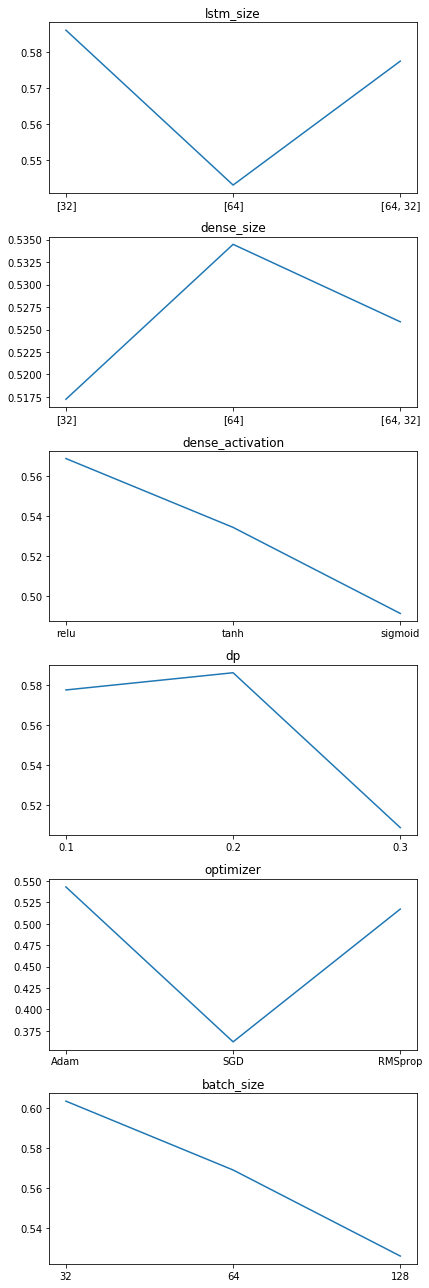

In [159]:
fig = plt.figure(figsize=(6, 18))

for i, result in enumerate(validation_results):
    ax = fig.add_subplot(len(validation_results), 1, i+1)
    hp_name = result[0]
    hp_errors = result[1]
    
    ax.set_title(hp_name)
    ax.plot(range(0, len(hp_errors)), hp_errors)
    plt.sca(ax)
    x_labels = hyperparams[hp_name]
    plt.xticks(range(0, len(hp_errors)), x_labels)
    
fig.tight_layout()
plt.show()

In [163]:
# edited function to return model
def evaluate_model(input_shape, output_shape,
                   hyperparams, train_set, validation_set,
                   train_epochs=100, verbose=0):
    model = simple_reccurent_model(trainX.shape[1], trainY.shape[1])
    model.compile(loss='categorical_crossentropy',
                  optimizer=hyperparams['optimizer'],
                  metrics=['accuracy'])
    
    model.fit(train_set[0], train_set[1], batch_size=hyperparams['batch_size'], epochs=train_epochs, verbose=verbose)
    _, train_accuracy = model.evaluate(train_set[0], train_set[1])
    _, validation_accuracy = model.evaluate(validation_set[0], validation_set[1])
    print("Train accuaracy:", train_accuracy, "Validation Accuracy:", validation_accuracy)
    return validation_accuracy, model

In [164]:
tuned_hyperparams = {
    'lstm_size': [32],
    'dp': 0.2,
    'dense_size': [64],
    'dense_activation': 'relu',
    'optimizer': 'adam',
    'batch_size': 32
}

acc, model = evaluate_model(trainX.shape[1], trainY.shape[1],
    tuned_hyperparams, (trainX, trainY), (validationX, validationY), 100, 1)

Epoch 1/100
931/931 [==============================] - 9s - loss: 1.5070 - acc: 0.3598     
Epoch 2/100
931/931 [==============================] - 8s - loss: 1.4436 - acc: 0.3878     
Epoch 3/100
931/931 [==============================] - 7s - loss: 1.4107 - acc: 0.3921     
Epoch 4/100
931/931 [==============================] - 7s - loss: 1.3747 - acc: 0.4135     
Epoch 5/100
931/931 [==============================] - 7s - loss: 1.3179 - acc: 0.4479     
Epoch 6/100
931/931 [==============================] - 8s - loss: 1.2612 - acc: 0.4586     
Epoch 7/100
931/931 [==============================] - 8s - loss: 1.2228 - acc: 0.4834     
Epoch 8/100
931/931 [==============================] - 8s - loss: 1.2100 - acc: 0.4608     
Epoch 9/100
931/931 [==============================] - 7s - loss: 1.1833 - acc: 0.4876     
Epoch 10/100
931/931 [==============================] - 7s - loss: 1.1677 - acc: 0.5124     
Epoch 11/100
931/931 [==============================] - 7s - loss: 1.1474 - acc

931/931 [==============================] - 8s - loss: 0.1104 - acc: 0.9549     
Epoch 90/100
931/931 [==============================] - 8s - loss: 0.1054 - acc: 0.9570     
Epoch 91/100
931/931 [==============================] - 8s - loss: 0.1071 - acc: 0.9592     
Epoch 92/100
931/931 [==============================] - 7s - loss: 0.1058 - acc: 0.9592     
Epoch 93/100
931/931 [==============================] - 8s - loss: 0.1069 - acc: 0.9603     
Epoch 94/100
931/931 [==============================] - 7s - loss: 0.1172 - acc: 0.9570     
Epoch 95/100
931/931 [==============================] - 8s - loss: 0.0915 - acc: 0.9646     
Epoch 96/100
931/931 [==============================] - 7s - loss: 0.0912 - acc: 0.9646     
Epoch 97/100
931/931 [==============================] - 8s - loss: 0.0985 - acc: 0.9603     
Epoch 98/100
931/931 [==============================] - 7s - loss: 0.0957 - acc: 0.9656     
Epoch 99/100
931/931 [==============================] - 8s - loss: 0.0898 - acc: 0.

In [165]:
tuned_hyperparams = {
    'lstm_size': [32],
    'dp': 0.5,
    'dense_size': [64],
    'dense_activation': 'relu',
    'optimizer': 'adam',
    'batch_size': 32
}

acc, model2 = evaluate_model(trainX.shape[1], trainY.shape[1],
    tuned_hyperparams, (trainX, trainY), (validationX, validationY), 50, 1)

Epoch 1/100
931/931 [==============================] - 9s - loss: 1.4675 - acc: 0.3695     
Epoch 2/100
931/931 [==============================] - 8s - loss: 1.4120 - acc: 0.4049     
Epoch 3/100
931/931 [==============================] - 8s - loss: 1.3542 - acc: 0.4264     
Epoch 4/100
931/931 [==============================] - 8s - loss: 1.3101 - acc: 0.4243     
Epoch 5/100
931/931 [==============================] - 8s - loss: 1.2824 - acc: 0.4490     
Epoch 6/100
931/931 [==============================] - 8s - loss: 1.2569 - acc: 0.4522     
Epoch 7/100
931/931 [==============================] - 8s - loss: 1.2167 - acc: 0.4726     
Epoch 8/100
931/931 [==============================] - 8s - loss: 1.1447 - acc: 0.5177     
Epoch 9/100
931/931 [==============================] - 8s - loss: 1.1598 - acc: 0.5134     
Epoch 10/100
931/931 [==============================] - 8s - loss: 1.1056 - acc: 0.5285     
Epoch 11/100
931/931 [==============================] - 8s - loss: 1.0655 - acc

931/931 [==============================] - 8s - loss: 0.1057 - acc: 0.9581     
Epoch 90/100
931/931 [==============================] - 8s - loss: 0.0920 - acc: 0.9624     
Epoch 91/100
931/931 [==============================] - 8s - loss: 0.1045 - acc: 0.9603     
Epoch 92/100
931/931 [==============================] - 8s - loss: 0.1026 - acc: 0.9624     
Epoch 93/100
931/931 [==============================] - 8s - loss: 0.0944 - acc: 0.9656     
Epoch 94/100
931/931 [==============================] - 8s - loss: 0.1043 - acc: 0.9603     
Epoch 95/100
931/931 [==============================] - 8s - loss: 0.1022 - acc: 0.9603     
Epoch 96/100
931/931 [==============================] - 8s - loss: 0.0938 - acc: 0.9603     
Epoch 97/100
931/931 [==============================] - 8s - loss: 0.0913 - acc: 0.9678     
Epoch 98/100
931/931 [==============================] - 8s - loss: 0.1014 - acc: 0.9613     
Epoch 99/100
931/931 [==============================] - 8s - loss: 0.0947 - acc: 0.

Third model and id didn't improve accuracy on validation set. We have a huge overfitting. Small dataset is the main suspect in that.

We have to reconsider the problem. Choosing the rating on 1-5 scale is quite arbitrary proccess. As we saw earlier when we inspected errors, there are misleading samples.

This time let's assume that rating of 1-3 is bad and of 4-5 is good. What is percentage of error in that case?

In [168]:
error_count = 0
for i, y in enumerate(validationY):
    #p = model.predict(np.array([validationX[i]])).round()[0].astype('int32')
    prediction = model2.predict(np.array([validationX[i]])).argmax() > 3
    actual = y.argmax() > 3
    if prediction != actual:
        print("Validation", i)
        print("Predicted review is good:", prediction, ", actual review is good:", actual)
        #print(validationX[i])
        text = []
        for word_i in validationX[i]:
            if word_i in reverse_word_map:
                text.append(reverse_word_map[word_i])
        print(' '.join(text))
        print()
        error_count+=1

Validation 7
Predicted review is good: False , actual review is good: True
love it

Validation 14
Predicted review is good: True , actual review is good: False
the ase of participating with echo

Validation 15
Predicted review is good: False , actual review is good: True
it works perfect

Validation 38
Predicted review is good: False , actual review is good: True
have these in almost every room i really have enjoyed them works perfectly

Validation 42
Predicted review is good: False , actual review is good: True
access to apps

Validation 52
Predicted review is good: True , actual review is good: False
still need more ai built into it to interact better it needs to continue the conversation sometimes if the finding answer needs to be right you can t keep stop alexa and ask again and again also it should be able to access the wikipedia dictionary in many areas with better and fast access needs to hear us better also we should be able to name it on our own instead calling alexa or echo p

In [173]:
print("Accuracy of prediction whether review was good:",(validationY.shape[0] - error_count)/validationY.shape[0] * 100)

Accuracy of prediction whether review was good: 84.48275862068965


That's more like it! 84% accuracy in prediction whether the review was good or bad.

The other helpful thing to use when analizing results is confucion matrix.

In [178]:
predicted = [x > 3 for x in model2.predict(validationX).argmax(axis=1)]
actual = [x > 3 for x in validationY.argmax(axis=1)]

In [182]:
from sklearn.metrics import confusion_matrix

True positive: 17 , True negative: 81 , False positive: 5 , False negative: 13


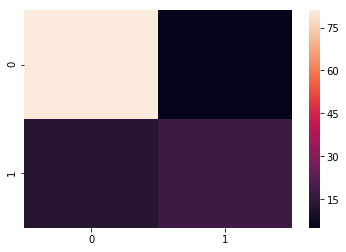

In [195]:
cnf_matrix = confusion_matrix(actual, predicted)
sns.heatmap(cnf_matrix)
tn, fp, fn, tp = cnf_matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
      ", False positive:", fp, ", False negative:", fn)

It seems like the validation set is severely unbalanced - it contains far more negative reviews than positive.

Regardless the confusion matrix results, in our case, for Amazon it would be worse to have False positive review than False negative, so our model's errors are rather acceptable.

Now let's check our model against the test data. If it is not as unbalanced as validation set, there are good chances that model will perform better.

In [197]:
test_accuracy = model2.evaluate(testX, testY)
print(test_accuracy)

117/117 [==============================] - 0s     
[2.8617358717144046, 0.54700855210296107]


## 55% of accuracy in precise predicitons.
Now let's check how model generally predicts whether reviews are good or not.

In [264]:
def check_general_accuracy(model, setX, setY):
    predicted = [x > 3 for x in model.predict(setX).argmax(axis=1)]
    actual = [x > 3 for x in setY.argmax(axis=1)]

    cnf_matrix = confusion_matrix(actual, predicted)
    sns.heatmap(cnf_matrix)
    tn, fp, fn, tp = cnf_matrix.ravel()
    print("True positive:", tp, ", True negative:", tn,
          ", False positive:", fp, ", False negative:", fn)

    print("Total accuracy:", (tp+tn)/testX.shape[0]*100)

True positive: 10 , True negative: 83 , False positive: 14 , False negative: 10
Total accuracy: 79.4871794872


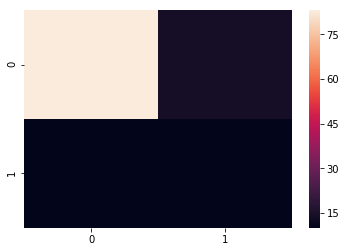

In [266]:
check_general_accuracy(model2, testX, testY)

We didn't get improvements in performing on test set, sadly. Nevertheless, **79,5%** of accuracy in predicting general moods of reviews.

Possible ways to improve model:
* get bigger dataset
* balance dataset better
* perform more diligent search for optimal hyperparameters
* try other models

# Convolutional model

Before wrapping up, let's try to solve this problem using another architecture of model.

We had a choice to treat each word in sentence as just another value and feed it into plain neural network, or treat it as a sequence in RNN, and we used it as such.

Now, we can try a somewhat middleground at this. Convolutional neural network, due to it's nature will have an effect of a sequence model with rolling window of chosen width.

In [201]:
from keras.layers import Conv1D, MaxPooling1D

In [328]:
def simple_conv_model(input_shape, output_shape):
    model = Sequential()
    model.add(embedding_layer)
    
    model.add(Conv1D(32, 5, activation='relu'))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Dropout(0.2))
        
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(output_shape, activation='softmax'))
    return model

In [329]:
model = simple_conv_model(trainX.shape[1], trainY.shape[1])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [327]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 370, 100)          295600    
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 366, 16)           8016      
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 362, 32)           2592      
_________________________________________________________________
dropout_73 (Dropout)         (None, 362, 32)           0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 11584)             0         
_________________________________________________________________
dense_124 (Dense)            (None, 64)                741440    
_________________________________________________________________
dropout_74 (Dropout)         (None, 64)                0         
__________

In [321]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights-improvements.hdf5",
     monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [322]:
model.fit(trainX, trainY, validation_data=(validationX, validationY),
          batch_size=64, callbacks=[checkpoint], epochs=10)

Train on 931 samples, validate on 116 samples
Epoch 1/10
931/931 [==============================] - 1s - loss: 0.1811 - acc: 0.9227 - val_loss: 3.1441 - val_acc: 0.5862
Epoch 2/10
931/931 [==============================] - 1s - loss: 0.1712 - acc: 0.9259 - val_loss: 3.1380 - val_acc: 0.6034
Epoch 3/10
931/931 [==============================] - 1s - loss: 0.1698 - acc: 0.9280 - val_loss: 3.2796 - val_acc: 0.6121
Epoch 4/10
931/931 [==============================] - 1s - loss: 0.1917 - acc: 0.9162 - val_loss: 2.8314 - val_acc: 0.5862
Epoch 5/10
931/931 [==============================] - 1s - loss: 0.1741 - acc: 0.9259 - val_loss: 3.1389 - val_acc: 0.5862
Epoch 6/10
931/931 [==============================] - 1s - loss: 0.1845 - acc: 0.9216 - val_loss: 3.0074 - val_acc: 0.6034
Epoch 7/10
931/931 [==============================] - 1s - loss: 0.1717 - acc: 0.9248 - val_loss: 3.5379 - val_acc: 0.6034
Epoch 8/10
931/931 [==============================] - 1s - loss: 0.1722 - acc: 0.9248 - val_l

In [323]:
model.load_weights("weights-improvements.hdf5")

Not too great in precise rating predictions.

True positive: 15 , True negative: 72 , False positive: 25 , False negative: 5
Total accuracy: 74.358974359


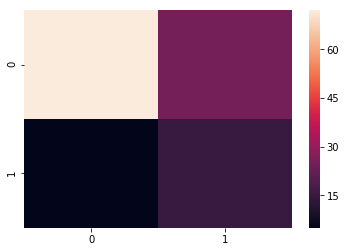

In [324]:
check_general_accuracy(model, testX, testY)

# 74% of general accuracy for convolutional network
Convolutional neural network predictions was slightly less accurate comparing to LSTM-based network, but no major tuning was performed.

Possible improvements stay same as for LSTM-based network:
* get bigger dataset
* balance dataset better
* perform more diligent search for optimal hyperparameters